In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Reshape, Conv2DTranspose, Embedding 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

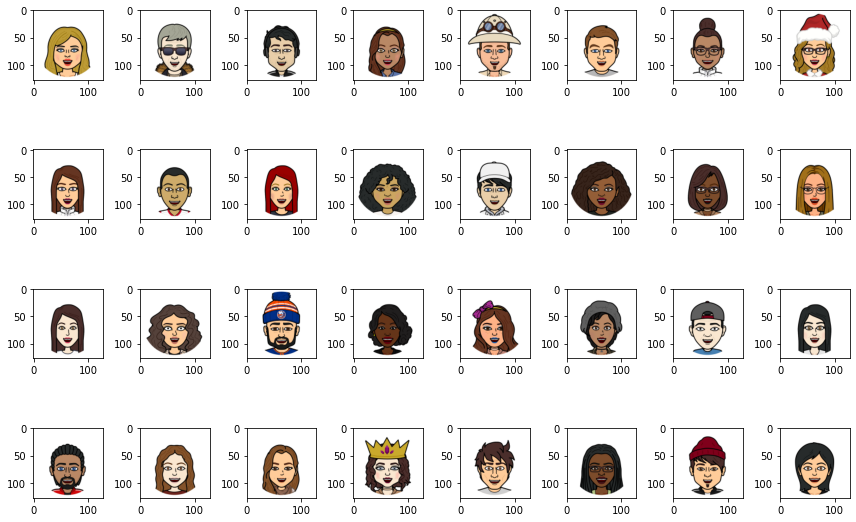

Image dimension in the dataset:  (128, 128, 3)


In [2]:
#Display some test images from the test set of tiny-imagenet
def display_formatted_image(d_choice, num_row, num_col):
    #see few examples
    # plot images
    d_size = 0
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    data_path = os.listdir(d_choice)
    for i in range(num_row*num_col):
        ax = axes[int(i/num_col), i%num_col]
        img = img_to_array(load_img(d_choice+data_path[np.random.choice(len(data_path))]))
        img = img.astype(int)
        
        d_size = img.shape
        ax.imshow(img)
        #ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()
    print("Image dimension in the dataset: ",d_size)
    
display_formatted_image("../Data/bit-emojis/images/", 4, 8)

In [3]:
def save_raw_data(dataloc, saveloc):
    folders = os.listdir(dataloc)
    X = []
    img_names = os.listdir(dataloc)
    for img in img_names:
        img = img_to_array(load_img(dataloc+img)).astype('uint8')
        X.append(img)
            
    X = np.array(X)
    
    with open(saveloc, 'wb') as fptr:
        np.save(fptr, X)
        
    print(X.shape)
#save_raw_data("../Data/bit-emojis/images/", "../Data/bit-emojis/emojis.npy")

(5, 128, 128, 3)
uint8


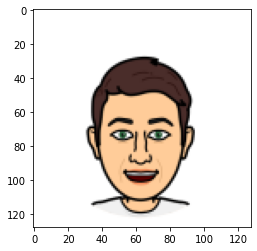

In [29]:
def display_images(data):
    print(data[0:5].shape)
    mx = np.max(data[0:5], axis=(1,2,3), keepdims=True)
    print(mx.dtype)
    mn = np.min(data[0:5].astype('float32'), axis=(1,2,3), keepdims=True)
    batch = 2*(data[0:5].astype('float32')-mn)/(mx-mn) - 1
    
    batch = (255*(batch+1)/2).astype('uint8')
    plt.imshow(batch[3])
display_images(np.load("../Data/bit-emojis/emojis.npy"))

In [12]:
class DC_GAN(object):
    def __init__(self):
        #These are suggested by DC gan paper
        self.arch_hyperparameters = {'l2_conv': 0.0001, 
                                     'dropout': 0.2,
                                     'lr': 0.0002,
                                     'beta1': 0.5,
                                     'batch_size': 128
                                     }
        
        self.noise_input= 100
        self.gen_inp_dim = (8, 8, 256)
        self.data_dims = (128, 128, 3)
        self.Generator = None
        self.Discriminator = None
        self.optimizer_g = None
        self.optimizer_d = None

    def save_model(self, path):
        self.Generator.save(path+"Generator")
        self.Discriminator.save(path+"Discriminator")
    
    def load_mymodel(self, path):
        print("Loading Model")
        self.Generator = load_model(path+"Generator")
        self.Generator.compile()
        self.Generator.summary()
    
        self.Discriminator = load_model(path+"Discriminator")
        self.Discriminator.compile()
        self.Discriminator.summary()
        
        self.optimizer_g = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr'], beta_1=self.arch_hyperparameters['beta1'])   
        self.optimizer_d = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr'], beta_1=self.arch_hyperparameters['beta1'])
    def generator(self, inp):
        #note: to use batch norm the data must have 0 mean atleast (pass image only after rescaling to [-1, 1])
        
        gen_op = Dense(self.gen_inp_dim[0]*self.gen_inp_dim[1]*self.gen_inp_dim[2], use_bias=False, name='project_enc')(inp)
        gen_op = BatchNormalization(name='gen_batch_norm_project')(gen_op)
        gen_op = Reshape(self.gen_inp_dim, name='reshape_enc')(gen_op)

        #the dc-gan tells us to use convolutions and batch norms and leaky relu (I am using elu, which is seen to be better)
        #inv_conv layer 1
        gen_op = Conv2DTranspose(128, (5, 5), strides=(2,2), padding='same', activation='relu', use_bias=False, name='gen_inv_conv_l1')(gen_op)
        #paper said use batch norm instead of regularization, normalization was done the channel dimension 
        gen_op = BatchNormalization(name='gen_batch_norm_l1')(gen_op)
        gen_op = Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same', activation='relu', use_bias=False, name='gen_inv_conv_l2')(gen_op)
        gen_op = BatchNormalization(name='gen_batch_norm_l2')(gen_op)
        gen_op = Conv2DTranspose(24, (5, 5), strides=(2,2), padding='same', activation='relu', use_bias=False, name='gen_inv_conv_l3')(gen_op)
        gen_op = BatchNormalization(name='gen_batch_norm_l3')(gen_op)
        #we want the output [-1, 1]: if you are using a batch normalization
        gen_op = Conv2DTranspose(3, (5, 5), strides=(2,2), padding='same', activation='tanh', use_bias=False, name='gen_inv_conv_l4')(gen_op)
        
        return gen_op
    
    def discriminator(self, inp):
        #conv_layer 1
        disc_op = Conv2D(12, (5,5), strides=(3,3), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'disc_conv_l1')(inp)
        #conv layer 2
        disc_op = Conv2D(24, (5,5), strides=(3,3), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'disc_conv_l2')(disc_op)
        disc_op = BatchNormalization(name='disc_batch_norm_l2')(disc_op)
        #conv layer 3
        disc_op = Conv2D(36, (3,3), strides=(2,2), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'disc_conv_l3')(disc_op)
        disc_op = BatchNormalization(name='disc_batch_norm_l3')(disc_op)
        #Flatten
        disc_op = Flatten(name='disc_flatten')(disc_op)
        #disc_op = Dropout(self.arch_hyperparameters['dropout'], name='disc_dropout')(disc_op)
        
        disc_op = Dense(1, activation='sigmoid', name='disc_output_layer')(disc_op)
        
        return disc_op
    
    def makeModel(self):
        #noise inp
        n_inp = Input(shape=self.noise_input, name='gen_input')
        self.Generator = Model(inputs=n_inp, outputs=self.generator(n_inp), name='Generator')
        self.Generator.compile()
        self.Generator.summary()
        #discriminator 
        disc_inp = Input(shape=self.data_dims, name='disc_input')
        self.Discriminator = Model(inputs=disc_inp, outputs=self.discriminator(disc_inp), name='Discriminator')
        self.Discriminator.compile()
        self.Discriminator.summary()
        
        self.optimizer_g = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr'], beta_1=self.arch_hyperparameters['beta1'])
        self.optimizer_d = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr'], beta_1=self.arch_hyperparameters['beta1'])
   
    def generate_image(self, bs):
        noise_vol = tf.random.uniform(minval=-1, maxval=1, shape=(bs, self.noise_input))
        return self.Generator(noise_vol)
    
    def loss(self, data_real, data_gen, JS_flag):
        rdat_log_likelihood = tf.reduce_mean(tf.math.log(self.Discriminator(data_real)))
        fake_log_likelihood = tf.reduce_mean(tf.math.log(1-self.Discriminator(data_gen)))
        gen_loss = None
        disc_loss = -1*(rdat_log_likelihood + fake_log_likelihood)
        if JS_flag == 1:
            #JS divergence
            gen_loss = fake_log_likelihood
        else:
            #this is the improvised loss
            gen_loss = tf.reduce_mean(-1*tf.math.log(self.Discriminator(data_gen)))
        return gen_loss, disc_loss
    
    def get_fake_real_acc(self, real, fake_data):
        r_acc = np.sum(self.Discriminator(real).numpy() >= 0.5)/real.shape[0]
        f_acc = np.sum(self.Discriminator(fake_data).numpy() < 0.5)/fake_data.shape[0]
        return r_acc, f_acc
    
    def back_prop_JS(self, data_real, data_gen_size, train_disc_flag=False):
        
        with tf.GradientTape(persistent=True) as tape:
            rdat_log_likelihood = None
            
            data_gen = self.generate_image(data_gen_size)

            if train_disc_flag == True:
                rdat_log_likelihood = tf.reduce_mean(tf.math.log(self.Discriminator(data_real)))
            #JS divergence 
            fake_log_likelihood = tf.reduce_mean(tf.math.log(1-self.Discriminator(data_gen)))
            #this is improvised loss
            #fake_log_likelihood = tf.reduce_mean(-1*tf.math.log(self.Discriminator(data_gen)))
            gen_loss = fake_log_likelihood 
            if train_disc_flag == True:
              #we try to maximize the sum and hence taking the negative
              disc_loss = -1*(fake_log_likelihood + rdat_log_likelihood)
        
        #train Generator
        gen_grad = tape.gradient(gen_loss, self.Generator.trainable_variables)
        self.optimizer_g.apply_gradients(zip(gen_grad, self.Generator.trainable_variables))
        #train Discriminator
        if train_disc_flag==True:
            disc_grad = tape.gradient(disc_loss, self.Discriminator.trainable_variables)
            self.optimizer_d.apply_gradients(zip(disc_grad, self.Discriminator.trainable_variables))
    
    def back_prop_impro(self, data_real, data_gen_size, disc_cycle):
        #train gen n times
        #noise = tf.random.uniform(minval=-1, maxval=1, shape=(data_gen_size, self.noise_input))
        for i in range(disc_cycle):
            with tf.GradientTape(persistent=True) as tape:
                #data_gen = self.Generator(noise)
                data_gen = self.generate_image(data_gen_size)
            
                rdat_log_likelihood = tf.reduce_mean(tf.math.log(self.Discriminator(data_real)))
                #this is improvised loss
                fake_log_likelihood = tf.reduce_mean(tf.math.log(1-self.Discriminator(data_gen)))
            
                #we try to maximize the sum and hence taking the negative
                disc_loss = -1*(fake_log_likelihood + rdat_log_likelihood)
            #train Discriminator
            disc_grad = tape.gradient(disc_loss, self.Discriminator.trainable_variables)
            self.optimizer_d.apply_gradients(zip(disc_grad, self.Discriminator.trainable_variables))
        
        with tf.GradientTape(persistent=True) as tape:
            data_gen = self.generate_image(data_gen_size)
            gen_loss = tf.reduce_mean(-1*tf.math.log(self.Discriminator(data_gen)))
        
        #train Generator
        gen_grad = tape.gradient(gen_loss, self.Generator.trainable_variables)
        self.optimizer_g.apply_gradients(zip(gen_grad, self.Generator.trainable_variables))

    
    def GAN_generate(self, batch_sz):
        batch = self.generate_image(batch_sz).numpy()
        #get the image scale back
        return (255*(batch+1)/2).astype('uint8')
    
    def prep_image(self, batch):
        #rescale to [-1, 1], as we will use batch norms later
        
        mx = np.max(batch, axis = (1,2,3), keepdims=True)
        mn = np.min(batch, axis = (1,2,3), keepdims=True)
        batch = batch.astype('float32')
        batch = 2*(batch-mn)/(mx-mn) - 1
        
        return batch
    
    def train_GAN(self, data, n_epochs, gen_cycle, JS_flag):
        
        ep_length = int(np.ceil(data.shape[0]/self.arch_hyperparameters['batch_size']))
        loss_history = {'gen_loss': [],
                        'disc_loss': []
                       }
        acc_history = {'r_acc': [],
                       'f_acc': [], 
                        }
        for i in range(n_epochs):
            d_loss_real = self.prep_image(data[np.random.choice(data.shape[0], 1000, replace=False)])
            d_loss_gen = self.generate_image(1000)
            
            gl, dl = self.loss(d_loss_real, d_loss_gen, JS_flag)
            r_acc, f_acc = self.get_fake_real_acc(d_loss_real, d_loss_gen)
            
            loss_history['disc_loss'].append(dl)
            loss_history['gen_loss'].append(gl)
            
            acc_history['r_acc'].append(r_acc)
            acc_history['f_acc'].append(f_acc)
            
            if i%2 == 0:
                print("Losses at epoch {}, generator: {} discriminator: {} \n Real Acc: {} Fake Acc: {}".format(i, gl, dl, r_acc, f_acc))
            
            np.random.shuffle(data)
            for j in range(ep_length):
                batch_real = None
                batch_fake_sz = self.arch_hyperparameters['batch_size']
                #batch_fake = self.generate_image(self.arch_hyperparameters['batch_size'])
                if j == ep_length - 1:
                    batch_real = data[j*self.arch_hyperparameters['batch_size']:data.shape[0]]
                else:
                    batch_real = data[j*(self.arch_hyperparameters['batch_size']):(j+1)*(self.arch_hyperparameters['batch_size'])]
            
                if JS_flag == 1:
                    #original image is between 0, 255, convert to [-1, 1]
                    #train the discriminator once in every gen_cycle examples
                    if j%gen_cycle == 0:
                        self.back_prop_JS(self.prep_image(batch_real), batch_fake_sz, True)
                    else:
                        self.back_prop_JS(self.prep_image(batch_real), batch_fake_sz, False)
                
                else:
                    self.back_prop_impro(self.prep_image(batch_real), batch_fake_sz, gen_cycle)
        return loss_history, acc_history


In [7]:
my_dc_gan = DC_GAN()
#generate uniform between -1 and 1
#gen_op = my_dc_gan.generator(tf.random.uniform(minval=-1, maxval=1, shape=(18, 8, 8, 512)))
#disc_res = my_dc_gan.discriminator(gen_op)
#print(gen_op.shape, disc_res.shape)
my_dc_gan.makeModel()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gen_input (InputLayer)      [(None, 8, 8, 256)]       0         
                                                                 
 gen_inv_conv_l1 (Conv2DTran  (None, 16, 16, 128)      819328    
 spose)                                                          
                                                                 
 gen_batch_norm_l1 (BatchNor  (None, 16, 16, 128)      512       
 malization)                                                     
                                                                 
 gen_inv_conv_l2 (Conv2DTran  (None, 32, 32, 64)       204864    
 spose)                                                          
                                                                 
 gen_batch_norm_l2 (BatchNor  (None, 32, 32, 64)       256       
 malization)                                             

In [4]:
data = np.load("../Data/bit-emojis/emojis.npy")

In [8]:
loss_history, acc_history = my_dc_gan.train_GAN(data, 5)

Losses at epoch 0, generator: 0.6903895735740662 discriminator: -0.02545708417892456 
 Real Acc: 0.689 Fake Acc: 0.434
Losses at epoch 2, generator: -0.0 discriminator: -0.0 
 Real Acc: 1.0 Fake Acc: 0.0
Losses at epoch 4, generator: -0.0 discriminator: -0.0 
 Real Acc: 1.0 Fake Acc: 0.0


In [9]:
def plot_comp_curves(losses, __title__, y_label, label):
    plt.plot(losses[label[0]], label=label[0])
    plt.plot(losses[label[1]], label=label[1])
    
    plt.legend()
    plt.xlabel('Epoch', size=15)
    plt.ylabel(y_label, size=15)
    plt.title(__title__, size=15)
    plt.show()

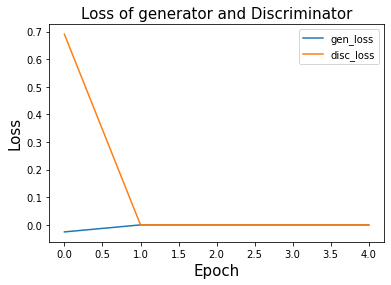

In [10]:
plot_comp_curves(loss_history, "Loss of generator and Discriminator", "Loss", ['gen_loss', 'disc_loss'])

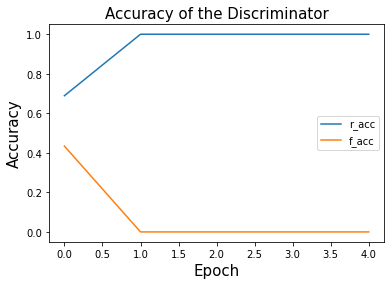

In [12]:
plot_comp_curves(acc_history, "Accuracy of the Discriminator", "Accuracy", ['r_acc', 'f_acc'])

In [13]:
def save_grid(data, savePath):
    from PIL import Image
    #tiny image is 64x64 
    grid_10_10 = Image.new('RGB', (1280,1280))
    idx = 0
    for i in range(0, 1280, 128):
        for j in range(0, 1280, 128):
            im = data[idx]
            im = Image.fromarray(im)
            grid_10_10.paste(im, (i,j))
            idx += 1
            
    grid_10_10.save(savePath)

In [14]:
img_100 = my_dc_gan.GAN_generate(100)
save_grid(img_100, "DC_Gen.jpg")

uint8


In [17]:
#this is used to create the 2 dataset
def create_Comparison(dataloc, r_save, model_loc, f_save):
    from PIL import Image
    #save 1000 real
    d_size = 10000
    #data_path = os.listdir(dataloc)
    #selected_idx = np.random.choice(len(data_path), size=d_size, replace=False)
    #ctr = 1
    #for idx in selected_idx:
    #    img = Image.open(dataloc+data_path[idx])
    #    img.save(r_save+str(ctr)+".png")
    #    ctr += 1
    #1000 generated images
    emoji_generator = DC_GAN()
    emoji_generator.load_mymodel(model_loc)
    for j in range(10):
        generated_emojis = emoji_generator.GAN_generate(1000)
        for i in range(1000):
            img = Image.fromarray(generated_emojis[i])
            img.save(f_save+str(j*1000 + i+1)+".png")
create_Comparison("../Data/bit-emojis/images/", "./FID/Real/", "./DC_GAN_3/", "./FID/Fake/")

Loading Model
Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gen_input (InputLayer)      [(None, 100)]             0         
                                                                 
 project_enc (Dense)         (None, 16384)             1638400   
                                                                 
 gen_batch_norm_project (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 reshape_enc (Reshape)       (None, 8, 8, 256)         0         
                                                                 
 gen_inv_conv_l1 (Conv2DTran  (None, 16, 16, 128)      819200    
 spose)                                                          
                                                                 
 gen_batch_norm_l1 (BatchNor  (None, 16, 16

In [1]:
#FID compute
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070 Ti Laptop GPU'

In [18]:
!python -m pytorch_fid "./FID/Real/" "./FID/Fake" --device cuda:0

FID:  227.54268712124065



100%|##########| 200/200 [00:50<00:00,  3.99it/s]

 36%|###6      | 73/200 [00:17<00:30,  4.13it/s]


100%|##########| 200/200 [00:48<00:00,  4.12it/s]


In [11]:
import numpy as np
x = np.array([[4, 5, 2, 1], [3, 0, 7, 9], [-1, 8, 11, 7]])
x = x.reshape(3, 2, 2)
print(x.shape)
print(x)

(3, 2, 2)
[[[ 4  5]
  [ 2  1]]

 [[ 3  0]
  [ 7  9]]

 [[-1  8]
  [11  7]]]


In [12]:
x = np.transpose(x, (1, 2, 0))

In [13]:
print(x)

[[[ 4  3 -1]
  [ 5  0  8]]

 [[ 2  7 11]
  [ 1  9  7]]]
